In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Importing Libraries

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        #filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    
    filename = f'/content/drive/My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [177]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [178]:
X_train.shape

(7352, 128, 9)

In [181]:
Y_train #its one hot encodeed already

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [182]:
print(Y_train.shape)


(7352, 6)


In [183]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))  #no. of input points
print(n_classes)

128
9
7352
6


- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

In [0]:
# Importing libraries
#from keras.models import Sequential
#from keras.layers import LSTM
#from keras.layers.core import Dense, Dropout

<h1> Divide and Conquer

In [0]:
from tensorflow.keras.layers import Dense, concatenate, Activation, Dropout ,Flatten, Input, LSTM , Embedding , Conv1D, MaxPooling1D
from tensorflow.keras.models import Model,Sequential
#from keras.models import Sequential

In [0]:
import itertools 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False,
                                    title='Confusion matrix',
                                    cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
                           

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


In [0]:
#mydata
#X_train, X_test, Y_train, Y_test

In [0]:
labels=['WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS','LAYING', 'SITTING','STANDING']

In [0]:
#Y_train[0][:3] <---- dynamic---1
#Y_train[0][3:] <---- static----0

In [189]:
#here we divide the y_train into 2 categories - dynamic and static

#TRAIN DATA

dyn_stat_lst= []

for i in range(len(Y_train)):
  if any(Y_train[i][:3]):    #i.e. for 0,1,2
    dyn_stat_lst.append(1)
  else:                      #i.e. for 3,4,5
    dyn_stat_lst.append(0)
    
dyn_stat_lst_train = np.array(dyn_stat_lst)[:, np.newaxis]
dyn_stat_lst_train.shape

(7352, 1)

In [190]:
#TEST DATA

dyn_stat_lst= []

for i in range(len(Y_test)):
  if any(Y_test[i][:3]):
    dyn_stat_lst.append(1)
  else:
    dyn_stat_lst.append(0)
    
dyn_stat_lst_test = np.array(dyn_stat_lst)[:, np.newaxis]
dyn_stat_lst_test.shape

(2947, 1)

In [191]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

dyn_stat_lst_train_owe = encoder.fit_transform(dyn_stat_lst_train.reshape(-1,1)).toarray()

dyn_stat_lst_test_owe = encoder.transform(dyn_stat_lst_test.reshape(-1,1)).toarray()


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [192]:
dyn_stat_lst_train_owe.shape

(7352, 2)

In [28]:
# Initiliazing the sequential model
  model = Sequential()

  model.add(LSTM(128, input_shape=(timesteps, input_dim)))

  model.add(Dropout(0.5))

  model.add(Dense(2, activation='sigmoid'))

  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#2nd form---- just in case


#input_1 = Input(shape=(timesteps, input_dim), name = 'first_stage')
#lstm  = LSTM(128)(input_1)
#d = Dropout(0.5)(lstm)
#dense = Dense(2, activation='sigmoid')(d)

In [30]:
history = model.fit(X_train, dyn_stat_lst_train_owe, batch_size= 16, epochs= 12, verbose=1, validation_data=(X_test, dyn_stat_lst_test_owe)) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7352 samples, validate on 2947 samples
Epoch 1/12
7352/7352 [==============================] - 113s 15ms/sample - loss: 0.4286 - acc: 0.8128 - val_loss: 0.3238 - val_acc: 0.8941
Epoch 2/12
7352/7352 [==============================] - 113s 15ms/sample - loss: 0.3387 - acc: 0.8615 - val_loss: 0.2751 - val_acc: 0.9057
Epoch 3/12
7352/7352 [==============================] - 113s 15ms/sample - loss: 0.6187 - acc: 0.6182 - val_loss: 0.5225 - val_acc: 0.7170
Epoch 4/12
7352/7352 [==============================] - 113s 15ms/sample - loss: 0.5822 - acc: 0.6474 - val_loss: 0.4739 - val_acc: 0.7635
Epoch 5/12
7352/7352 [==============================] - 113s 15ms/sample - loss: 0.1820 - acc: 0.9378 - val_loss: 0.0890 - val_acc: 0.9752
Epoch 6/12
7352/7352 [==============================] - 114s 16ms/sample - loss: 0.0319 - acc: 0.9921 - val_loss: 0.0332 - val_acc: 0.9912
Epoch 7/12
7352/7352 [==

In [31]:
_,acc_val = model.evaluate(X_test,dyn_stat_lst_test_owe,verbose=0)
_,acc_train = model.evaluate(X_train,dyn_stat_lst_train_owe,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 0.99959195 test_accuracy 0.9976247


The model classifies data into static and dynamic with very high accuracy

<h2> second stage

In [32]:
#here we divide the y_train into 2 categories - dynamic and static

#TRAIN DATA ----- Y

static= []
dynamic = []

index_static_train=[]   # all the indexes which get divided into static and dynamic will be stored in these 2 lists. we'll use these 2 lists to divide our X_train into static and dynamic sections
index_dynamic_train = []

for i in range(len(Y_train)):
  if any(Y_train[i][:3]):
    dynamic.append(Y_train[i][:3])
    index_dynamic_train.append(i)
    
  else:
    static.append(Y_train[i][3:])
    index_static_train.append(i)
    
Y_dynamic_train = np.array(dynamic)
print(Y_dynamic_train.shape)

Y_static_train = np.array(static)
print(Y_static_train.shape)

(3285, 3)
(4067, 3)


In [194]:
Y_static_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [33]:
#TEST DATA--------Y

static= []
dynamic = []

index_static_test=[]   # all the indexes which get divided into static and dynamic will be stored in these 2 lists. we'll use these 2 lists to divide our X_train into static and dynamic sections
index_dynamic_test = []

for i in range(len(Y_test)):
  if any(Y_test[i][:3]):
    dynamic.append(Y_test[i][:3])
    index_dynamic_test.append(i)
    
  else:
    static.append(Y_test[i][3:])
    index_static_test.append(i)
    
Y_dynamic_test = np.array(dynamic)
print(Y_dynamic_test.shape)

Y_static_test = np.array(static)
print(Y_static_test.shape)

(1387, 3)
(1560, 3)


In [34]:
#diving x_train into dynamic and static dataset

#TRAIN------X

X_dynamic = [X_train[i] for i in index_dynamic_train]
X_static =  [X_train[i] for i in index_static_train]


X_dynamic_train = np.array(X_dynamic)
print(X_dynamic_train.shape)

X_static_train = np.array(X_static)
print(X_static_train.shape)

(3285, 128, 9)
(4067, 128, 9)


In [35]:
#TEST------X

X_dynamic = [X_test[i] for i in index_dynamic_test]
X_static =  [X_test[i] for i in index_static_test]

X_dynamic_test = np.array(X_dynamic)
print(X_dynamic_test.shape)

X_static_test = np.array(X_static)
print(X_static_test.shape)



(1387, 128, 9)
(1560, 128, 9)


<h1> stage 2 dynamic

In [36]:
print(X_dynamic_train.shape)
print(Y_dynamic_train.shape)

print(X_dynamic_test.shape)
print(Y_dynamic_test.shape)

(3285, 128, 9)
(3285, 3)
(1387, 128, 9)
(1387, 3)


In [0]:
#stage 2 - dynamic

input_21 = Input(shape = (128,9,), name = 'stage_2_dynamic') 
conv_1 = Conv1D(100, kernel_size = (3), activation = 'relu', padding = 'same')(input_21)
maxpool_1 = MaxPooling1D(pool_size = (100), strides =(3))(conv_1)

f1 = Flatten()(maxpool_1)
d1 =Dropout(0.5)(f1)
main_output_dynamic = Dense(3, activation = 'softmax')(d1)



In [0]:
model_21= Model(inputs=[input_21], outputs= main_output_dynamic)


In [0]:
model_21.compile(loss='mean_squared_error', optimizer = 'adam',  metrics = ['accuracy'])

In [54]:
result = model_21.fit(X_dynamic_train , Y_dynamic_train, batch_size = 32 , epochs = 35, verbose =1, validation_data = (X_dynamic_test, Y_dynamic_test))

Train on 3285 samples, validate on 1387 samples
Epoch 1/35
3285/3285 [==============================] - 1s 396us/sample - loss: 4.2314e-05 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9416
Epoch 2/35
3285/3285 [==============================] - 1s 387us/sample - loss: 1.3063e-05 - acc: 1.0000 - val_loss: 0.0287 - val_acc: 0.9510
Epoch 3/35
3285/3285 [==============================] - 1s 387us/sample - loss: 8.8884e-06 - acc: 1.0000 - val_loss: 0.0279 - val_acc: 0.9503
Epoch 4/35
3285/3285 [==============================] - 1s 386us/sample - loss: 2.1378e-04 - acc: 0.9994 - val_loss: 0.0381 - val_acc: 0.9286
Epoch 5/35
3285/3285 [==============================] - 1s 388us/sample - loss: 6.5914e-05 - acc: 1.0000 - val_loss: 0.0261 - val_acc: 0.9503
Epoch 6/35
3285/3285 [==============================] - 1s 386us/sample - loss: 4.1626e-05 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9358
Epoch 7/35
3285/3285 [==============================] - 1s 393us/sample - loss: 1.8554e-05 - acc: 1.

In [55]:
_,acc_val = model_21.evaluate(X_dynamic_test, Y_dynamic_test,verbose=0)
_,acc_train = model_21.evaluate(X_dynamic_train, Y_dynamic_train,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy', acc_val)

Train_accuracy 1.0 test_accuracy 0.9459265


In [0]:
import matplotlib.pyplot as plt 
import seaborn as sns

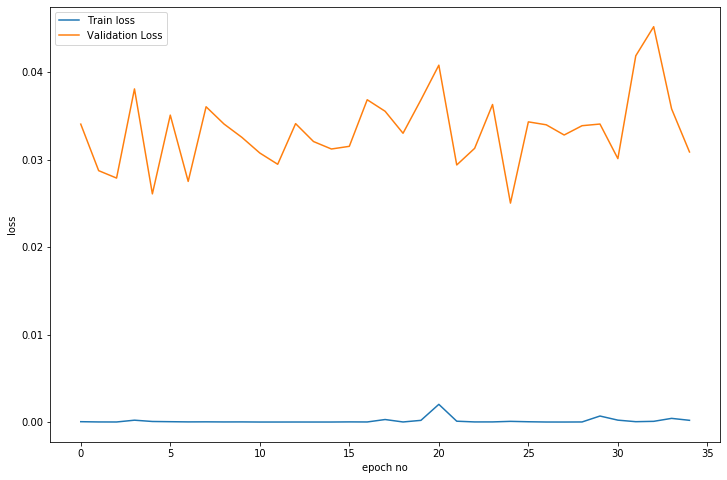

In [60]:
plt.figure(figsize=(12,8))
plt.plot(result.history['loss'],label='Train loss')
plt.plot(result.history['val_loss'],label = 'Validation Loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

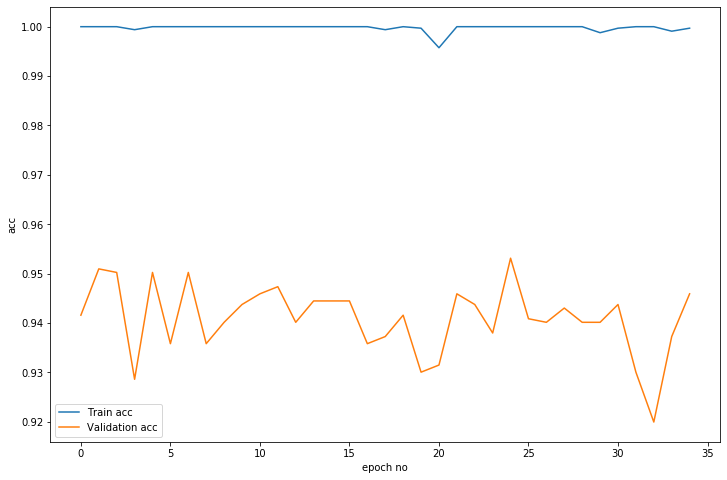

In [62]:
plt.figure(figsize=(12,8))
plt.plot(result.history['acc'],label='Train acc')
plt.plot(result.history['val_acc'],label = 'Validation acc')
plt.xlabel('epoch no')
plt.ylabel('acc')
plt.legend()
plt.show()

In [0]:

# Activities are the class labels
# It is a 3 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS'
}

# Utility function to print the confusion matrix
def confusion_matrix_(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return confusion_matrix(Y_true, Y_pred)

In [75]:
cm = confusion_matrix_(Y_dynamic_test, model_21.predict(X_dynamic_test))
cm

array([[450,  32,  14],
       [  1, 416,   3],
       [  1,  24, 446]])

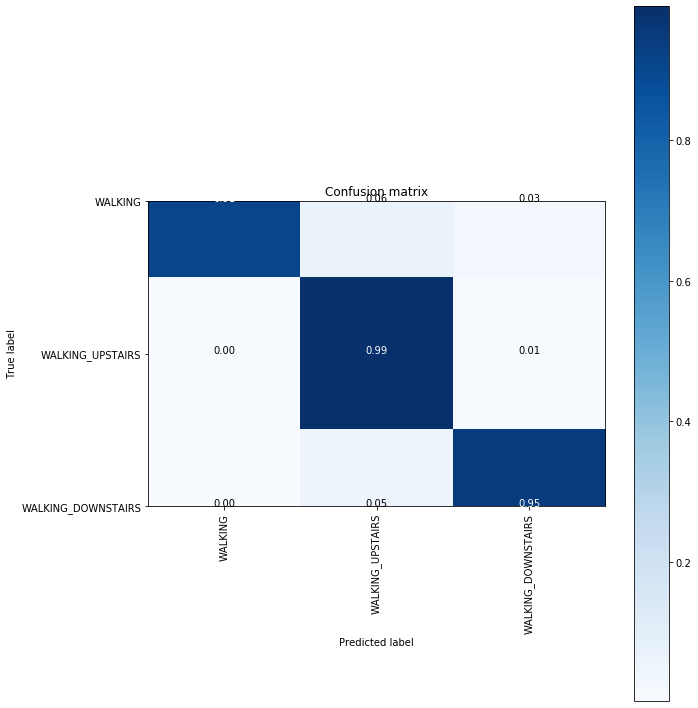

In [91]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'], normalize = True)
plt.show()

<h1> stage 2 static

In [0]:
input_22 = Input(shape = (128,9,), name = 'stage_2_static') 
conv_21 = Conv1D(30, kernel_size = (3), activation = 'relu', padding = 'same')(input_22) 
conv_22 = Conv1D(50, kernel_size = (3), activation = 'relu', padding = 'same')(conv_21)
d1= Dropout(0.5)(conv_22)
maxpool_1 = MaxPooling1D(pool_size = (100), strides =(3))(d1)
conv_23 = Conv1D(100, kernel_size = (3), activation = 'relu', padding = 'same')(maxpool_1)


f1 = Flatten()(conv_23)
d1= Dropout(0.5)(f1)
main_output_static = Dense(3, activation = 'softmax')(d1)




In [0]:
model_22= Model(inputs=[input_22], outputs= main_output_static)


In [0]:
model_22.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [102]:
result = model_22.fit(X_static_train , Y_static_train, batch_size = 32 , epochs = 30, verbose =1, validation_data = (X_static_test, Y_static_test))

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 2s 565us/sample - loss: 0.0357 - acc: 0.9857 - val_loss: 0.2992 - val_acc: 0.9282
Epoch 2/30
4067/4067 [==============================] - 2s 567us/sample - loss: 0.0235 - acc: 0.9899 - val_loss: 0.3413 - val_acc: 0.9154
Epoch 3/30
4067/4067 [==============================] - 2s 566us/sample - loss: 0.0318 - acc: 0.9872 - val_loss: 0.2358 - val_acc: 0.9359
Epoch 4/30
4067/4067 [==============================] - 2s 572us/sample - loss: 0.0274 - acc: 0.9916 - val_loss: 0.2717 - val_acc: 0.9385
Epoch 5/30
4067/4067 [==============================] - 2s 576us/sample - loss: 0.0243 - acc: 0.9924 - val_loss: 0.3009 - val_acc: 0.9269
Epoch 6/30
4067/4067 [==============================] - 2s 575us/sample - loss: 0.0206 - acc: 0.9931 - val_loss: 0.3815 - val_acc: 0.9141
Epoch 7/30
4067/4067 [==============================] - 2s 559us/sample - loss: 0.0279 - acc: 0.9899 - val_loss: 0.2740 - va

In [103]:
_,acc_val = model_22.evaluate(X_static_test, Y_static_test,verbose=0)
_,acc_train = model_22.evaluate(X_static_train, Y_static_train,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy', acc_val)

Train_accuracy 0.99827886 test_accuracy 0.93846154


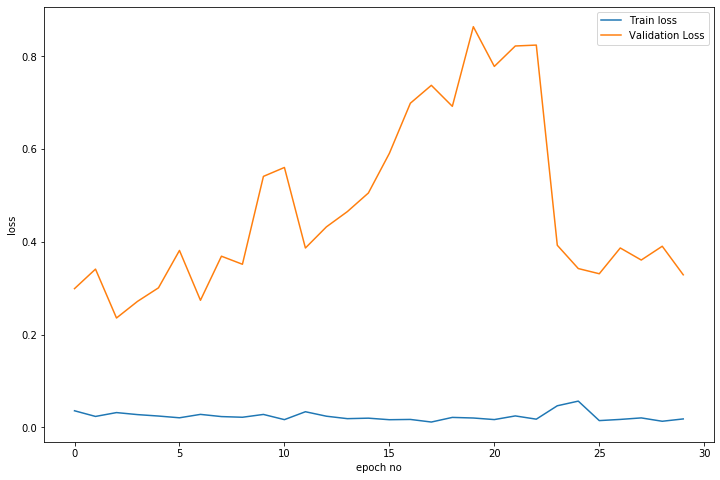

In [122]:
plt.figure(figsize=(12,8))
plt.plot(result.history['loss'],label='Train loss')
plt.plot(result.history['val_loss'],label = 'Validation Loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

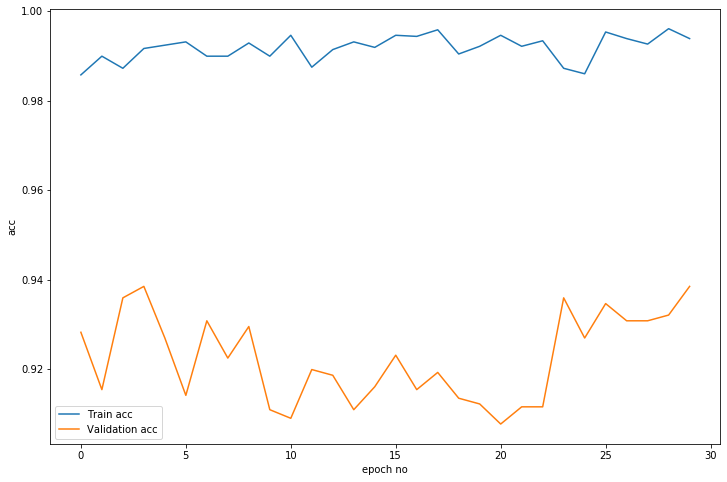

In [123]:
plt.figure(figsize=(12,8))
plt.plot(result.history['acc'],label='Train acc')
plt.plot(result.history['val_acc'],label = 'Validation acc')
plt.xlabel('epoch no')
plt.ylabel('acc')
plt.legend()
plt.show()

In [0]:
# Activities are the class labels
# It is a 3 class classification
ACTIVITIES = {
    0: 'SITTING',
    1: 'STANDING',
    2: 'LAYING'
}

# Utility function to print the confusion matrix
def confusion_matrix_(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return confusion_matrix(Y_true, Y_pred)

In [108]:
cm = confusion_matrix_(Y_static_test, model_22.predict(X_static_test))
cm

array([[537,   0,   0],
       [  3, 420,  68],
       [  0,  25, 507]])

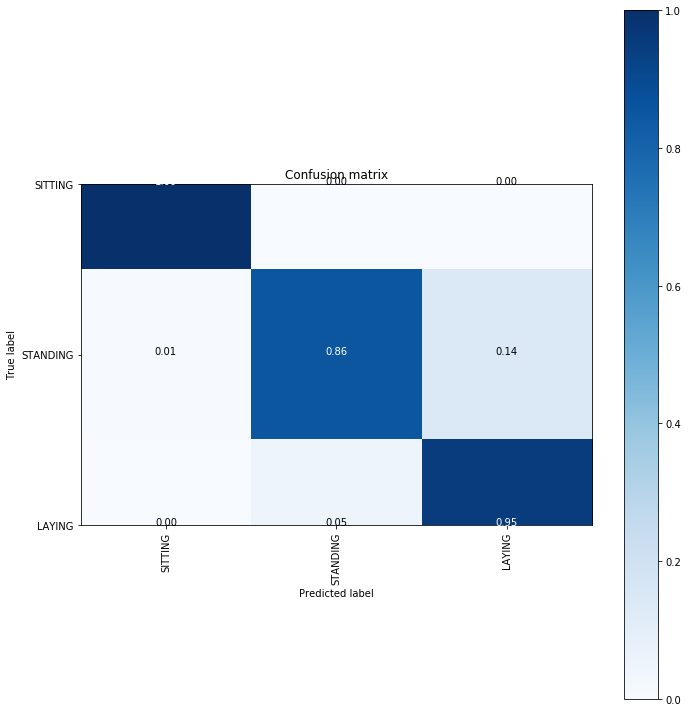

In [113]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes = ['SITTING','STANDING','LAYING'], normalize = True)
plt.show()

<h1>Combining 3 models

Steps:

1. predicting labels as 0 or 1 i.e. static or dynamic with stage 1 model - 'model' 
2. dividing X into X_static and X_dynamic based on the predicted labels
3. With the help of second stage model 'model_21' dynamic data was predicted and with the help of second stage model 'model_22' static data was predicted.
4. final prediction list was formed by appending the two second stage 
predicted lists according to the y_predicted labels of stage 1.


(steps repeated for both train and test data)

In [0]:
#X_train, X_test, Y_train, Y_test

In [0]:
###TRAIN
predict_2class = model.predict(X_train)

In [0]:
y_predict_2class = np.argmax(predict_2class, axis=1)

In [261]:
y_predict_2class 

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
X_dynamic = X_train[y_predict_2class ==1]
X_static = X_train[y_predict_2class ==0]

In [263]:
predict_dynamic = model_21.predict(X_dynamic) #just predicting the x data which was predicted as 'dynamic' by the stage 1 model.

predict_dynamic = np.argmax(predict_dynamic, axis=1) #takes the position/index which has the highest value

np.unique(predict_dynamic)

array([0, 1, 2])

In [264]:
predict_static = model_22.predict(X_static) #just predicting the x data which was predicted as 'static' by the stage 1 model.

predict_static = np.argmax(predict_static, axis=1) #takes the position/index which has the highest value

#replacing 0,1,2 with 3,4,5 --- so that we get 6 unique values at the end(0-5)
predict_static[predict_static ==0] = 3 
predict_static[predict_static ==1] = 4
predict_static[predict_static ==2] = 5


print(np.unique(predict_static))

[3 4 5]


In [265]:
print(y_predict_2class.shape)
print(predict_static.shape)
print(predict_dynamic.shape)

(7352,)
(4064,)
(3288,)


In [0]:
final_pred_train = [] #this will be the final predicted list of our complete divide and conquer model for train data
i,j=0,0

for k in y_predict_2class:
  if k ==1:
    final_pred_train.append(predict_dynamic[i])
    i+=1
  else:
    final_pred_train.append(predict_static[j])
    j+=1

In [267]:
(len(final_pred_train))

7352

In [0]:
###TEST
predict_2class = model.predict(X_test)
y_predict_2class = np.argmax(predict_2class, axis=1)

X_dynamic = X_test[y_predict_2class ==1]
X_static = X_test[y_predict_2class ==0]


predict_dynamic = model_21.predict(X_dynamic) #just predicting the x data which was predicted as 'dynamic' by the stage 1 model.
predict_dynamic = np.argmax(predict_dynamic, axis=1) #takes the position/index which has the highest value


predict_static = model_22.predict(X_static) #just predicting the x data which was predicted as 'static' by the stage 1 model.

predict_static = np.argmax(predict_static, axis=1) #takes the position/index which has the highest value

#replacing 0,1,2 with 3,4,5 --- so that we get 6 unique values at the end(0-5)
predict_static[predict_static ==0] = 3 
predict_static[predict_static ==1] = 4
predict_static[predict_static ==2] = 5


final_pred_test = [] #this will be the final predicted list of our complete divide and conquer model for train data
i,j=0,0

for k in y_predict_2class:
  if k ==1:
    final_pred_test.append(predict_dynamic[i])
    i+=1
  else:
    final_pred_test.append(predict_static[j])
    j+=1


In [269]:
print(y_predict_2class.shape)
print(predict_static.shape)
print(predict_dynamic.shape)

(2947,)
(1555,)
(1392,)


In [270]:
(len(final_pred_test))

2947

In [271]:
final_pred_train = np.array(final_pred_train)[:, np.newaxis]
print(final_pred_train.shape)

final_pred_test = np.array(final_pred_test)[:, np.newaxis]
print(final_pred_test.shape)


(7352, 1)
(2947, 1)


In [272]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

final_pred_train_owe = encoder.fit_transform(final_pred_train.reshape(-1,1)).toarray()

final_pred_test_owe = encoder.transform(final_pred_test.reshape(-1,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [273]:
print(final_pred_train_owe.shape)
print(final_pred_test_owe.shape)

print(Y_train.shape)
print(Y_test.shape)

(7352, 6)
(2947, 6)
(7352, 6)
(2947, 6)


In [282]:
from sklearn.metrics import accuracy_score
print('Accuracy of train data',accuracy_score(Y_train,final_pred_train_owe))
print('Accuracy of test data',accuracy_score(Y_test,final_pred_test_owe))

Accuracy of train data 0.9986398258977149
Accuracy of test data 0.9395995928062436


In [280]:
cm = confusion_matrix_(Y_test, final_pred_test_owe)
cm

array([[536,   0,   0,   0,   0,   1],
       [  3, 420,  68,   0,   0,   0],
       [  0,  25, 502,   3,   0,   2],
       [  0,   0,   0, 450,  32,  14],
       [  0,   0,   0,   1, 416,   3],
       [  0,   1,   0,   1,  24, 445]])

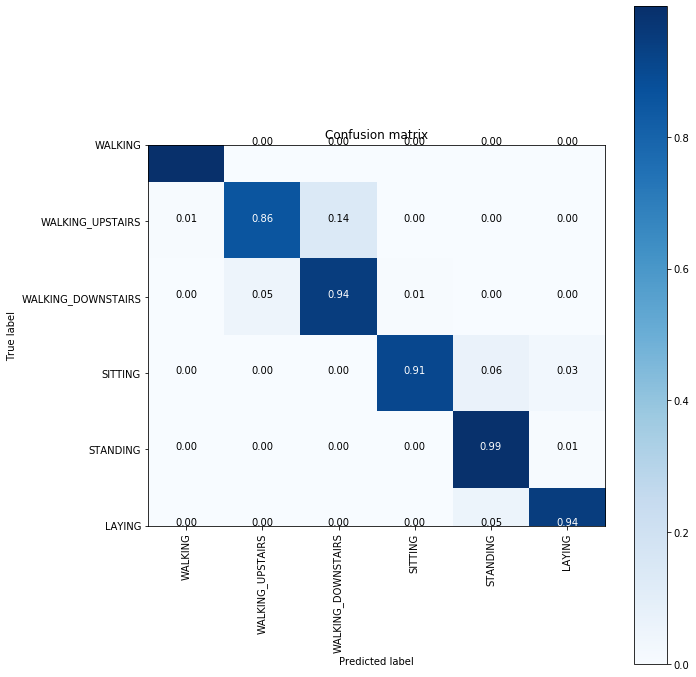

In [281]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING'], normalize = True)
plt.show()



The final accuracies received with Divide and Conquer approach on the HAR datase are -
 and 

*   Train Accuracy -  99.86%
*   Test Accuracy -  93.96%


